In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics

In [2]:
abNormalhHeartData = pd.read_csv('archive/ptbdb_abnormal.csv', header=None)
normalhHeartData = pd.read_csv('archive/ptbdb_normal.csv', header=None)

print('Abnormal heart data information')
abNormalhHeartData.info()

print('Normal heart data information')
normalhHeartData.info()

Abnormal heart data information
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10506 entries, 0 to 10505
Columns: 188 entries, 0 to 187
dtypes: float64(188)
memory usage: 15.1 MB
Normal heart data information
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4046 entries, 0 to 4045
Columns: 188 entries, 0 to 187
dtypes: float64(188)
memory usage: 5.8 MB


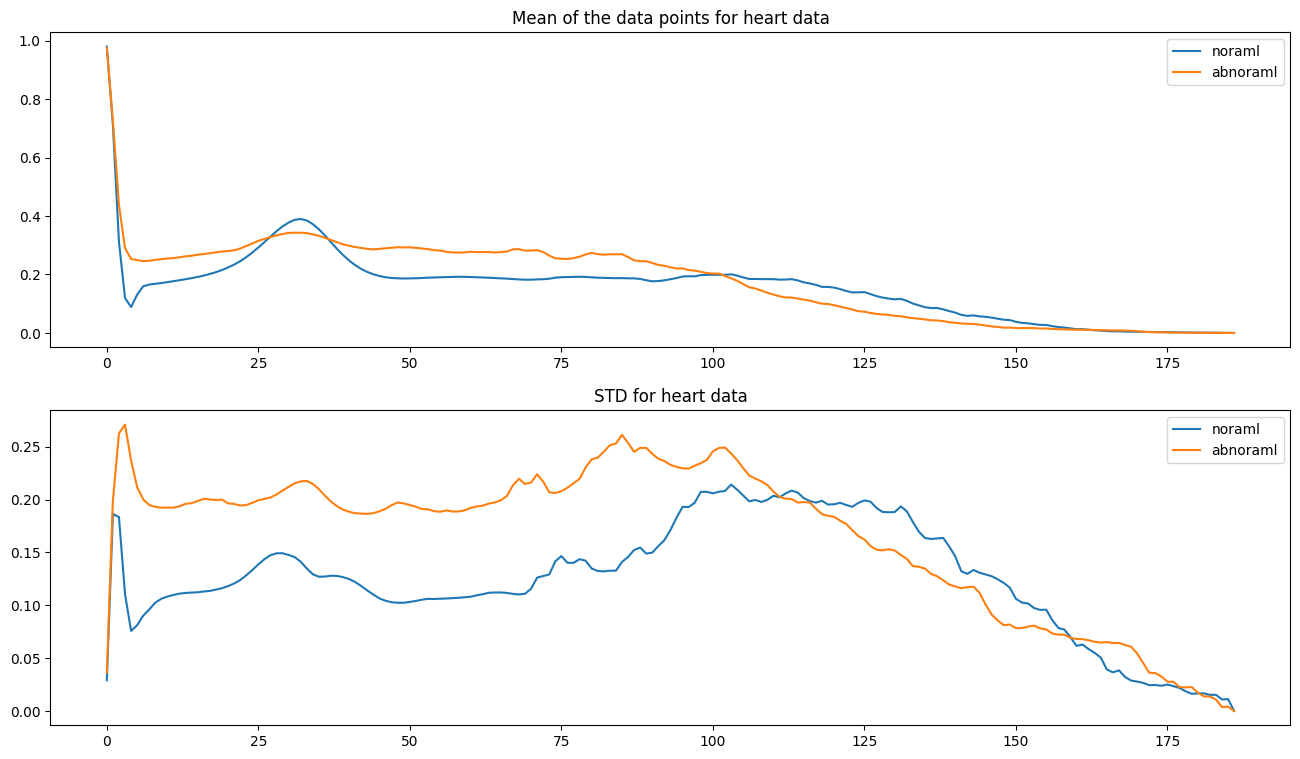

In [3]:
_, (ax1,ax2) = plt.subplots(2,1, figsize=(16,9))

ax1.plot(normalhHeartData.loc[:,:186].mean(), label='noraml')
ax1.plot(abNormalhHeartData.loc[:,:186].mean(), label='abnoraml')
ax1.set_title("Mean of the data points for heart data")
ax1.legend()


ax2.plot(normalhHeartData.loc[:,:186].std(), label='noraml')
ax2.plot(abNormalhHeartData.loc[:,:186].std(), label='abnoraml')
ax2.legend()
ax2.set_title("STD for heart data")
plt.savefig('data.png')

In [4]:
from sklearn.utils import resample
normalhHeartData = resample(normalhHeartData, replace=True, n_samples=len(abNormalhHeartData), random_state=42)

### Concatenate the abnormal data with the normal one

In [5]:
all_heart_data = pd.concat([abNormalhHeartData, normalhHeartData], axis=0, ignore_index=True)
print(all_heart_data.info())
all_heart_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21012 entries, 0 to 21011
Columns: 188 entries, 0 to 187
dtypes: float64(188)
memory usage: 30.1 MB
None


,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,0.932233,0.869679,0.886186,0.929626,0.908775,0.933970,0.801043,0.749783,0.687229,0.635100,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.000000,0.606941,0.384181,0.254237,0.223567,0.276836,0.253430,0.184826,0.153349,0.121872,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1.000000,0.951613,0.923963,0.853303,0.791859,0.734255,0.672043,0.685100,0.670507,0.667435,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.977819,0.899261,0.230129,0.032348,0.142329,0.223660,0.328096,0.367837,0.381701,0.389094,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.935618,0.801661,0.805815,1.000000,0.722741,0.480789,0.454829,0.319834,0.266874,0.308411,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


### Make sure that we have only two classes

In [6]:
all_heart_data.loc[:,187].value_counts()

1.0    10506
0.0    10506
Name: 187, dtype: int64

### Drop target values

In [7]:
X = all_heart_data.drop(all_heart_data.columns[187], axis=1)
X.head()

,0,1,2,3,4,5,6,7,8,9,...,177,178,179,180,181,182,183,184,185,186
0,0.932233,0.869679,0.886186,0.929626,0.908775,0.933970,0.801043,0.749783,0.687229,0.635100,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.000000,0.606941,0.384181,0.254237,0.223567,0.276836,0.253430,0.184826,0.153349,0.121872,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.951613,0.923963,0.853303,0.791859,0.734255,0.672043,0.685100,0.670507,0.667435,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.977819,0.899261,0.230129,0.032348,0.142329,0.223660,0.328096,0.367837,0.381701,0.389094,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.935618,0.801661,0.805815,1.000000,0.722741,0.480789,0.454829,0.319834,0.266874,0.308411,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
true_labels = all_heart_data.loc[:,187]
true_labels.head()

0    1.0
1    1.0
2    1.0
3    1.0
4    1.0
Name: 187, dtype: float64

#### Mini-Batch K-Means from scratch

In [9]:
n_clusters = 2

# Mini Batch K-Means parameters
batch_size = 100
max_iters = 100
tolerance = 0.0001

# Initialize cluster centers randomly
np.random.seed(0)
initial_centers = X.sample(n_clusters).to_numpy()

# Main Mini Batch K-Means algorithm
centers = initial_centers.copy()
for _ in range(max_iters):
    batch = X.sample(batch_size)
    distances = np.linalg.norm(batch.values[:, np.newaxis] - centers, axis=2)
    labels = np.argmin(distances, axis=1)
    new_centers = np.array([batch[labels == i].mean(axis=0) for i in range(n_clusters)])
    
    if np.all(np.abs(new_centers - centers) < tolerance):
        break
    
    centers = new_centers

# Assign cluster labels to the entire dataset
distances = np.linalg.norm(X.values[:, np.newaxis] - centers, axis=2)
predicted_labels = np.argmin(distances, axis=1)

In [10]:
true_labels = all_heart_data.iloc[:, 187]
accuracy = np.mean(predicted_labels == true_labels)

print("Accuracy:", accuracy)

# homogeneity: each cluster contains only members of a single class.
homogeneity = metrics.homogeneity_score(true_labels, predicted_labels)
print("Homogeneity:", metrics.homogeneity_score(true_labels, predicted_labels))
# completeness: all members of a given class are assigned to the same cluster.
completeness = metrics.completeness_score(true_labels, predicted_labels)
print("Completeness:", metrics.completeness_score(true_labels, predicted_labels))
# v-measure: harmonic mean of homogeneity and completeness
v_measure = metrics.v_measure_score(true_labels, predicted_labels)
print("V-measure:", metrics.v_measure_score(true_labels, predicted_labels))

Accuracy: 0.4139539310869979
Homogeneity: 0.029768478562126652
Completeness: 0.03741623183726201
V-measure: 0.03315707662358934


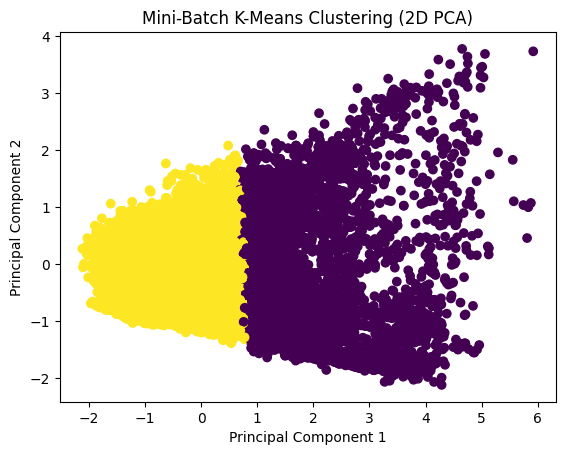

In [11]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=predicted_labels, cmap='viridis')
plt.title("Mini-Batch K-Means Clustering (2D PCA)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.savefig('scratch_mini_batch.png')
plt.show()

### prebuilt Mini-batch K means

In [12]:
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score

# Initialize the K-Means model with 2 clusters
kmeans = KMeans(n_clusters=2, random_state=0)

# Fit the model to your data
kmeans.fit(X)

# Get the cluster labels
cluster_labels = kmeans.labels_

# Since K-Means assigns cluster numbers arbitrarily, you need to map cluster labels to your target labels
# You can do this by comparing the majority label in each cluster to your target label
cluster0_majority_label = np.bincount(all_heart_data.iloc[:, 187][cluster_labels == 0]).argmax()
cluster1_majority_label = np.bincount(all_heart_data.iloc[:, 187][cluster_labels == 1]).argmax()

# Map cluster labels to target labels
predicted_labels = np.where(cluster_labels == 0, cluster0_majority_label, cluster1_majority_label)

# Calculate the accuracy
accuracy = accuracy_score(all_heart_data.iloc[:, 187], predicted_labels)
print("Accuracy:", accuracy)

# homogeneity: each cluster contains only members of a single class.
homogeneity = metrics.homogeneity_score(true_labels, predicted_labels)
print("Homogeneity:", metrics.homogeneity_score(true_labels, predicted_labels))
# completeness: all members of a given class are assigned to the same cluster.
completeness = metrics.completeness_score(true_labels, predicted_labels)
print("Completeness:", metrics.completeness_score(true_labels, predicted_labels))
# v-measure: harmonic mean of homogeneity and completeness
v_measure = metrics.v_measure_score(true_labels, predicted_labels)
print("V-measure:", metrics.v_measure_score(true_labels, predicted_labels))

C:\Users\Актоты\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Accuracy: 0.5920426422996383
Homogeneity: 0.03204974896878738
Completeness: 0.03855707618767319
V-measure: 0.03500354562174401


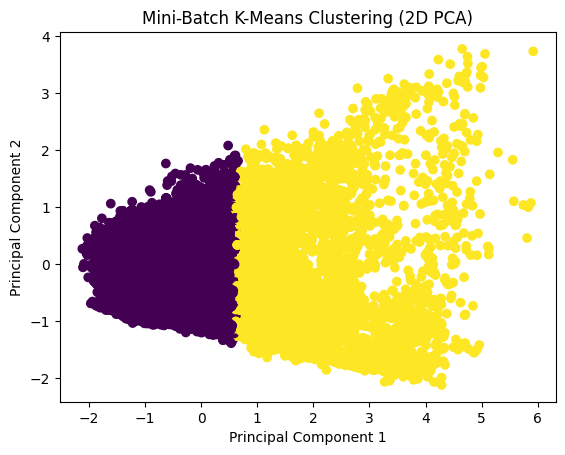

In [13]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=predicted_labels, cmap='viridis')
plt.title("Mini-Batch K-Means Clustering (2D PCA)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.savefig('prebuilt_mini_batch.png')
plt.show()

### Birch

In [14]:
from sklearn.cluster import Birch

birch = Birch(threshold=0.05, n_clusters=2)
cluster_labels = birch.fit_predict(X)

accuracy = accuracy_score(all_heart_data.iloc[:, 187], cluster_labels)
print("Accuracy:", accuracy)

# homogeneity: each cluster contains only members of a single class.
homogeneity = metrics.homogeneity_score(true_labels, cluster_labels)
print("Homogeneity:", homogeneity)
# completeness: all members of a given class are assigned to the same cluster.
completeness = metrics.completeness_score(true_labels, cluster_labels)
print("Completeness:", completeness)
# v-measure: harmonic mean of homogeneity and completeness
v_measure = metrics.v_measure_score(true_labels, cluster_labels)
print("V-measure:", v_measure)

Accuracy: 0.4099562154959071
Homogeneity: 0.026820522720549578
Completeness: 0.029402594434754768
V-measure: 0.02805226718049536


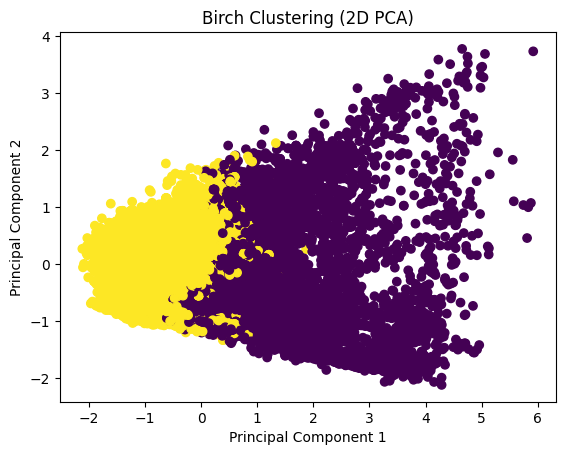

In [15]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap='viridis')
plt.title("Birch Clustering (2D PCA)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.savefig('birch.png')
plt.show()